# Interaction Effects and Non-Parametric Regression

**Chapter 6, Section 3**

This notebook covers interaction terms for heterogeneous treatment effects and categorical (non-parametric) regression.

## Table of Contents
1. [Intuition](#intuition) - Why interactions matter
2. [Formal Treatment](#formal) - Interaction term interpretation
3. [Numeric Demonstration](#numeric) - Effect heterogeneity by IQ
4. [Implementation](#implementation) - Non-parametric with `C()`
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### Breaking the Parallel Lines Assumption

In the previous notebook, we assumed treatment effects are **constant** across covariate values. But what if:

- Education helps low-IQ workers **more** than high-IQ workers?
- Or the reverse: education has bigger returns for high-IQ workers?

This is **effect heterogeneity**: the treatment effect varies by individual characteristics.

To capture this, we add an **interaction term**:

$$Y = \alpha + \beta_1 T + \beta_2 X + \beta_3 (T \times X) + \epsilon$$

Now:
- Effect when X = 0: $\beta_1$
- Effect when X = x: $\beta_1 + \beta_3 \cdot x$

★ Insight ─────────────────────────────────────
- Without interaction: Parallel lines (constant effect)
- With interaction: Non-parallel lines (effect varies by X)
- $\beta_3$ measures how much the effect changes per unit X
─────────────────────────────────────────────────

In [2]:
# Load data
wage = load_facure_data("wage.csv")
wage['high_educ'] = (wage['educ'] > 12).astype(int)

print(f"Data loaded: {len(wage)} observations")

Data loaded: 935 observations


---

## Formal Treatment

### Interaction Model Interpretation

$$Y = \alpha + \beta_1 T + \beta_2 X + \beta_3 (T \times X) + \epsilon$$

**For control group (T = 0)**:
$$E[Y | T=0, X] = \alpha + \beta_2 X$$

**For treatment group (T = 1)**:
$$E[Y | T=1, X] = (\alpha + \beta_1) + (\beta_2 + \beta_3) X$$

**Coefficient interpretations**:

| Coefficient | Interpretation |
|-------------|----------------|
| $\alpha$ | Mean outcome for control when X = 0 |
| $\beta_1$ | Treatment effect when X = 0 |
| $\beta_2$ | Effect of X in control group |
| $\beta_3$ | **How treatment effect changes per unit X** |

The treatment effect at any X is:
$$\tau(X) = \beta_1 + \beta_3 X$$

In [3]:
# Estimate model with interaction
# Using statsmodels formula: T*IQ expands to T + IQ + T:IQ
model_interaction = smf.ols('wage ~ high_educ * IQ', data=wage).fit()

print("Model: wage ~ high_educ + IQ + high_educ:IQ")
print("=" * 55)
print(ols_summary_table(model_interaction)[['Coefficient', 'Std. Error', 'p-value']])

Model: wage ~ high_educ + IQ + high_educ:IQ
              Coefficient  Std. Error  p-value
Intercept        338.6836    120.7886   0.0052
high_educ        -11.5188    192.7938   0.9524
IQ                 5.3729      1.2648   0.0000
high_educ:IQ       1.5320      1.8688   0.4126


In [4]:
# Compare with non-interaction model
model_no_interaction = smf.ols('wage ~ high_educ + IQ', data=wage).fit()

print("\nComparison:")
print(f"Without interaction: ATE = ${model_no_interaction.params['high_educ']:.2f} (constant)")
print(f"With interaction:")
print(f"  Effect at IQ=80:  ${model_interaction.params['high_educ'] + model_interaction.params['high_educ:IQ']*80:.2f}")
print(f"  Effect at IQ=100: ${model_interaction.params['high_educ'] + model_interaction.params['high_educ:IQ']*100:.2f}")
print(f"  Effect at IQ=120: ${model_interaction.params['high_educ'] + model_interaction.params['high_educ:IQ']*120:.2f}")


Comparison:
Without interaction: ATE = $144.85 (constant)
With interaction:
  Effect at IQ=80:  $111.04
  Effect at IQ=100: $141.68
  Effect at IQ=120: $172.32


---

## Numeric Demonstration

### Visualizing Non-Parallel Lines

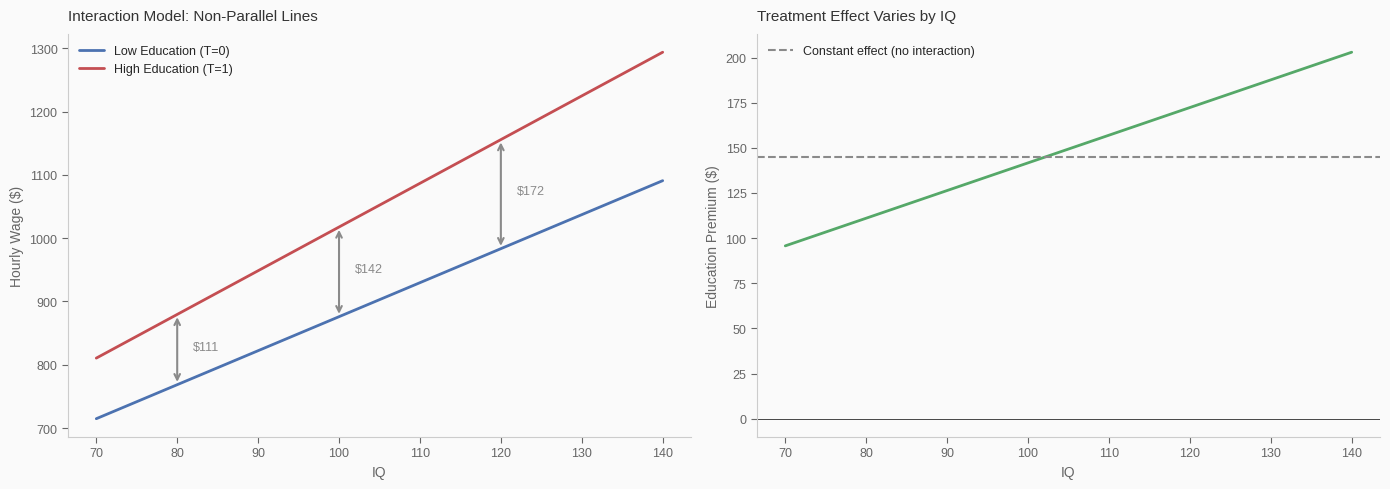


Interaction coefficient (β₃): 1.53
Interpretation: Each point of IQ changes the education premium by $1.53


In [5]:
# Extract coefficients
alpha = model_interaction.params['Intercept']
beta1 = model_interaction.params['high_educ']
beta2 = model_interaction.params['IQ']
beta3 = model_interaction.params['high_educ:IQ']

# Create visualization
fig, axes = create_tufte_figure(ncols=2, figsize=(14, 5))

# Left: Non-parallel lines from interaction model
ax = axes[0]
iq_range = np.linspace(70, 140, 100)

y_control = alpha + beta2 * iq_range
y_treated = (alpha + beta1) + (beta2 + beta3) * iq_range

ax.plot(iq_range, y_control, color=COLORS['blue'], linewidth=2, label='Low Education (T=0)')
ax.plot(iq_range, y_treated, color=COLORS['red'], linewidth=2, label='High Education (T=1)')

# Add arrows showing varying gap
for iq_val in [80, 100, 120]:
    y0 = alpha + beta2 * iq_val
    y1 = (alpha + beta1) + (beta2 + beta3) * iq_val
    gap = y1 - y0
    ax.annotate('', xy=(iq_val, y1), xytext=(iq_val, y0),
                arrowprops=dict(arrowstyle='<->', color=COLORS['gray'], lw=1.5))
    ax.text(iq_val + 2, (y0 + y1)/2, f'${gap:.0f}', fontsize=9, color=COLORS['gray'])

set_tufte_title(ax, "Interaction Model: Non-Parallel Lines")
set_tufte_labels(ax, "IQ", "Hourly Wage ($)")
ax.legend(loc='upper left', frameon=False)

# Right: Treatment effect as function of IQ
ax = axes[1]
effect = beta1 + beta3 * iq_range
ax.plot(iq_range, effect, color=COLORS['green'], linewidth=2)
ax.axhline(y=model_no_interaction.params['high_educ'], color=COLORS['gray'], 
           linestyle='--', linewidth=1.5, label='Constant effect (no interaction)')
ax.axhline(y=0, color='black', linewidth=0.5)

set_tufte_title(ax, "Treatment Effect Varies by IQ")
set_tufte_labels(ax, "IQ", "Education Premium ($)")
ax.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

print(f"\nInteraction coefficient (β₃): {beta3:.2f}")
print(f"Interpretation: Each point of IQ changes the education premium by ${beta3:.2f}")

### Non-Parametric Regression with Categorical Variables

An extreme form of flexibility is to **not assume any functional form** for the covariate. Instead of:

$$Y = \alpha + \beta_1 T + \beta_2 X + \epsilon$$

We use:

$$Y = \alpha + \sum_j \gamma_j \cdot \mathbf{1}[X = j] + \epsilon$$

This creates a **separate intercept** for each value of X—no linearity assumption!

In [6]:
# Non-parametric: treat each education level as separate category
model_nonparam = smf.ols('wage ~ C(educ)', data=wage).fit()

print("Non-parametric regression: wage ~ C(educ)")
print(f"Number of parameters: {len(model_nonparam.params)}")
print(f"R-squared: {model_nonparam.rsquared:.4f}")
print("\nFirst 10 coefficients:")
print(model_nonparam.params.head(10))

Non-parametric regression: wage ~ C(educ)
Number of parameters: 10
R-squared: 0.1091

First 10 coefficients:
Intercept       774.3000
C(educ)[T.10]   -54.8143
C(educ)[T.11]    44.5140
C(educ)[T.12]    88.3718
C(educ)[T.13]   171.8294
C(educ)[T.14]   215.7130
C(educ)[T.15]   324.6111
C(educ)[T.16]   334.4133
C(educ)[T.17]   417.1500
C(educ)[T.18]   426.5246
dtype: float64


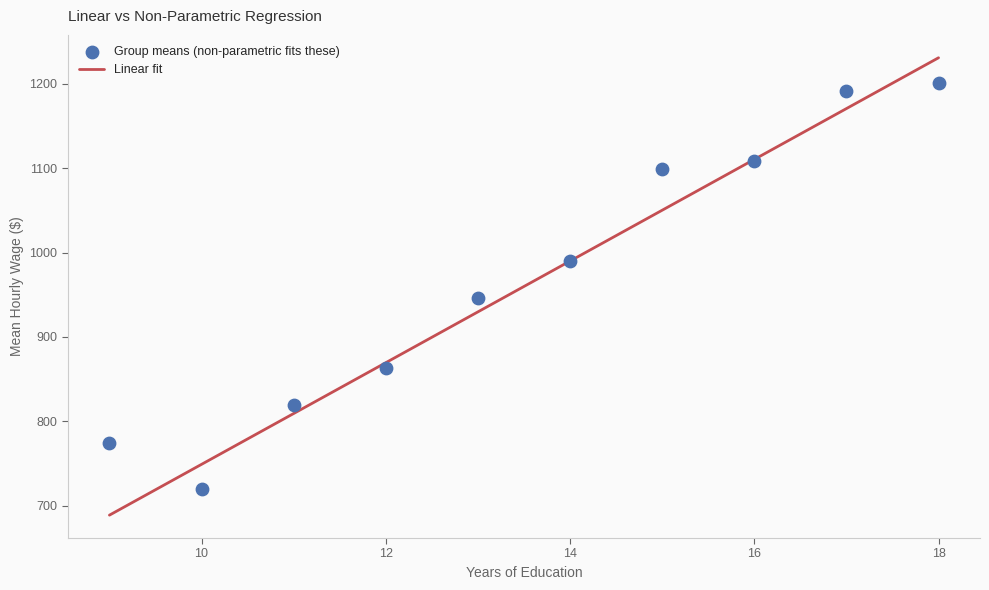


Linear: wage = 146.95 + 60.21 × educ
Non-parametric: Separate mean for each education level (interpolation of points)


In [7]:
# Compare parametric vs non-parametric
model_linear = smf.ols('wage ~ educ', data=wage).fit()

# Get fitted values
wage_temp = wage.copy()
wage_temp['fitted_linear'] = model_linear.fittedvalues
wage_temp['fitted_nonparam'] = model_nonparam.fittedvalues

# Group means for visualization
group_means = wage.groupby('educ')['wage'].mean()

fig, ax = create_tufte_figure(figsize=(10, 6))

# Plot group means (what non-parametric fits exactly)
ax.scatter(group_means.index, group_means.values, s=80, c=COLORS['blue'], 
           label='Group means (non-parametric fits these)', zorder=3)

# Plot linear fit
educ_range = np.linspace(wage['educ'].min(), wage['educ'].max(), 100)
ax.plot(educ_range, model_linear.params['Intercept'] + model_linear.params['educ'] * educ_range,
        color=COLORS['red'], linewidth=2, label='Linear fit')

set_tufte_title(ax, "Linear vs Non-Parametric Regression")
set_tufte_labels(ax, "Years of Education", "Mean Hourly Wage ($)")
ax.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

print(f"\nLinear: wage = {model_linear.params['Intercept']:.2f} + {model_linear.params['educ']:.2f} × educ")
print(f"Non-parametric: Separate mean for each education level (interpolation of points)")

---

## Implementation

### Interaction Syntax in Statsmodels

```python
# Full syntax: main effects + interaction
smf.ols('Y ~ T + X + T:X', data=df)  # Explicit
smf.ols('Y ~ T * X', data=df)         # Shorthand (expands to T + X + T:X)

# Interaction only (rare, usually include main effects)
smf.ols('Y ~ T:X', data=df)
```

In [8]:
# Function to compute heterogeneous treatment effects
def compute_cate(model, treatment_var, interaction_var, values):
    """
    Compute Conditional Average Treatment Effects (CATE) from interaction model.
    
    Parameters
    ----------
    model : statsmodels result
        Fitted model with interaction term.
    treatment_var : str
        Name of treatment variable.
    interaction_var : str
        Name of variable interacted with treatment.
    values : array-like
        Values at which to compute CATE.
        
    Returns
    -------
    pd.DataFrame
        CATE at each value.
    """
    interaction_term = f"{treatment_var}:{interaction_var}"
    
    beta_T = model.params[treatment_var]
    beta_interaction = model.params.get(interaction_term, 0)
    
    cate = beta_T + beta_interaction * np.array(values)
    
    return pd.DataFrame({
        interaction_var: values,
        'CATE': cate
    })

# Example usage
cate_results = compute_cate(model_interaction, 'high_educ', 'IQ', [80, 90, 100, 110, 120])
print("Conditional Average Treatment Effects:")
print(cate_results)

Conditional Average Treatment Effects:
    IQ     CATE
0   80 111.0395
1   90 126.3593
2  100 141.6791
3  110 156.9989
4  120 172.3186


---

## Interview Appendix

### Practice Questions

**Q1: How do you interpret an interaction term in regression?**

<details>
<summary>Solution</summary>

For model $Y = \alpha + \beta_1 T + \beta_2 X + \beta_3 (T \times X) + \epsilon$:

- $\beta_1$ is the effect of T **when X = 0**
- $\beta_3$ is **how much the effect of T changes** per unit increase in X
- The effect of T at any value X is: $\tau(X) = \beta_1 + \beta_3 X$

Equivalently:
- $\beta_2$ is the effect of X **when T = 0**
- $\beta_3$ is how much the effect of X changes when T = 1 vs T = 0

**Key insight**: The interaction coefficient is symmetric—it measures how either variable modifies the effect of the other.

</details>

**Q2: When should you include an interaction term?**

<details>
<summary>Solution</summary>

Include interactions when you believe:
1. **Effect heterogeneity exists**: Treatment effect varies by subgroup
2. **You want to test for heterogeneity**: Is the interaction coefficient significant?
3. **Theory suggests moderation**: One variable modifies the effect of another

Signs you might need interaction:
- Residual plots show patterns by a covariate
- Subgroup analyses show very different effects
- Domain knowledge suggests effect modification

Warning: Adding interactions increases model complexity and can reduce precision on main effects. Only include if theoretically motivated or statistically justified.

</details>

**Q3: What's the advantage of non-parametric regression with `C(educ)`?**

<details>
<summary>Solution</summary>

**Advantages**:
1. **No functional form assumption**: Doesn't assume linear relationship
2. **Captures any pattern**: Can fit non-monotonic relationships
3. **Estimates group means exactly**: Each coefficient is the difference from the reference category mean

**Disadvantages**:
1. **Uses more degrees of freedom**: One parameter per category (minus reference)
2. **No interpolation**: Can't predict for unseen category values
3. **Less precision**: Doesn't "borrow strength" across similar values

**When to use**: 
- When you don't trust linearity assumption
- When you have enough data in each category
- When the covariate is naturally categorical or has few unique values

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 6.

[^2]: Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Section 3.3.

[^3]: Cross-reference: OVB formula in `05_linear_regression/04_omitted_variable_bias.ipynb`